In [1]:
!rm -r ~/.kaggle
! mkdir ~/.kaggle
from google.colab import files
files.upload() 
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download plameneduardo/sarscov2-ctscan-dataset

 92% 212M/230M [00:01<00:00, 204MB/s]
100% 230M/230M [00:01<00:00, 173MB/s]


In [3]:
! unzip sarscov2-ctscan-dataset

Archive:  sarscov2-ctscan-dataset.zip
  inflating: COVID/Covid (1).png     
  inflating: COVID/Covid (10).png    
  inflating: COVID/Covid (100).png   
  inflating: COVID/Covid (1000).png  
  inflating: COVID/Covid (1001).png  
  inflating: COVID/Covid (1002).png  
  inflating: COVID/Covid (1003).png  
  inflating: COVID/Covid (1004).png  
  inflating: COVID/Covid (1005).png  
  inflating: COVID/Covid (1006).png  
  inflating: COVID/Covid (1007).png  
  inflating: COVID/Covid (1008).png  
  inflating: COVID/Covid (1009).png  
  inflating: COVID/Covid (101).png   
  inflating: COVID/Covid (1010).png  
  inflating: COVID/Covid (1011).png  
  inflating: COVID/Covid (1012).png  
  inflating: COVID/Covid (1013).png  
  inflating: COVID/Covid (1014).png  
  inflating: COVID/Covid (1015).png  
  inflating: COVID/Covid (1016).png  
  inflating: COVID/Covid (1017).png  
  inflating: COVID/Covid (1018).png  
  inflating: COVID/Covid (1019).png  
  inflating: COVID/Covid (102).png   
  inflating:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

## Data

In [5]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/'
train_dir = os.path.join(data_dir)

In [6]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (470).png,0,COVID
1,COVID/Covid (871).png,0,COVID
2,COVID/Covid (1119).png,0,COVID
3,COVID/Covid (548).png,0,COVID
4,COVID/Covid (74).png,0,COVID


## Randomize the order of training set

In [7]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train))
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (584).png,0,COVID
1,COVID/Covid (1112).png,0,COVID
2,non-COVID/Non-Covid (26).png,1,non-COVID
3,non-COVID/Non-Covid (921).png,1,non-COVID
4,COVID/Covid (543).png,0,COVID


## Plot a Pie Chart

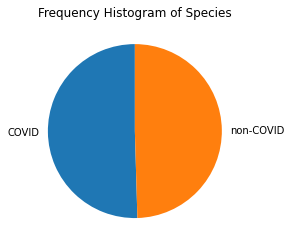

<Figure size 864x864 with 0 Axes>

In [14]:
plt.pie(train['DiseaseID'].value_counts(), labels=['COVID', 'non-COVID'], startangle = 90)
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

## Display images of COVID

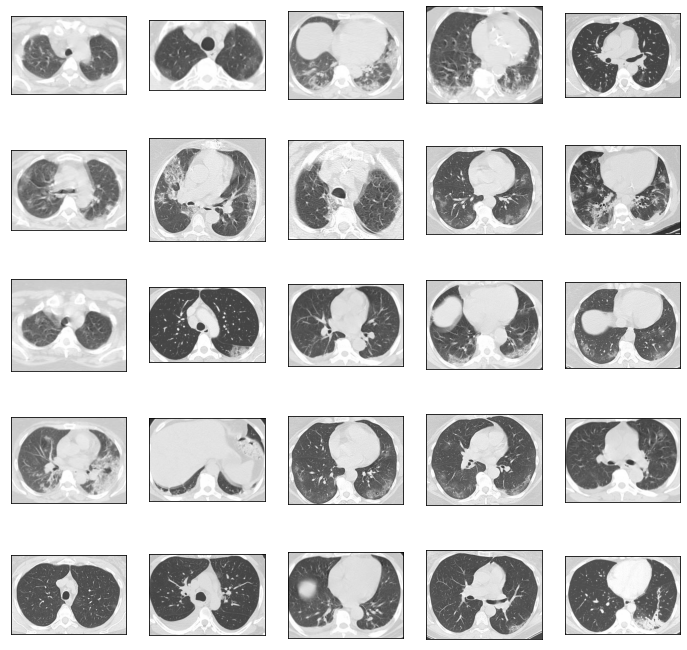

In [15]:

def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

## Display images of non-COVID

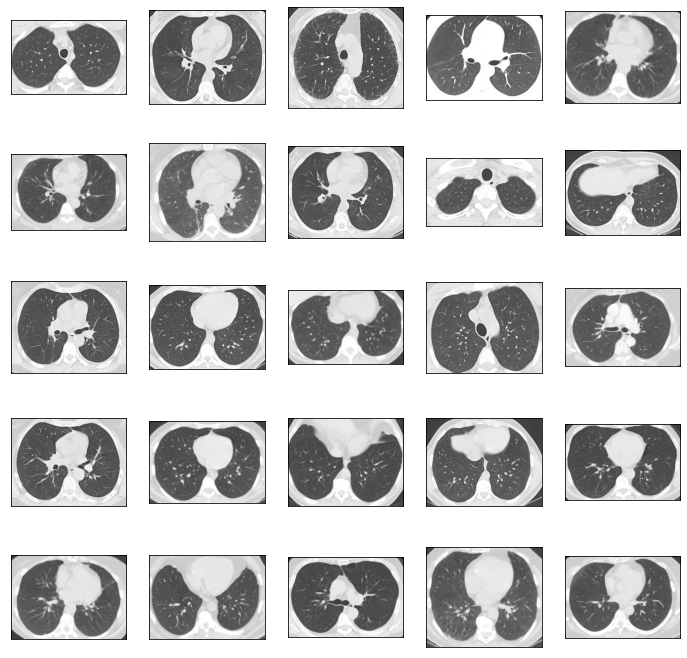

In [16]:

def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

## Image Read and Resize Function

In [17]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

## Training Images

In [18]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:09, 254.22it/s]


Train Shape: (2481, 64, 64, 3)


## Converting Labels to Categorical

In [19]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

## Train Test Splitting

In [20]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

## 64*64 training images

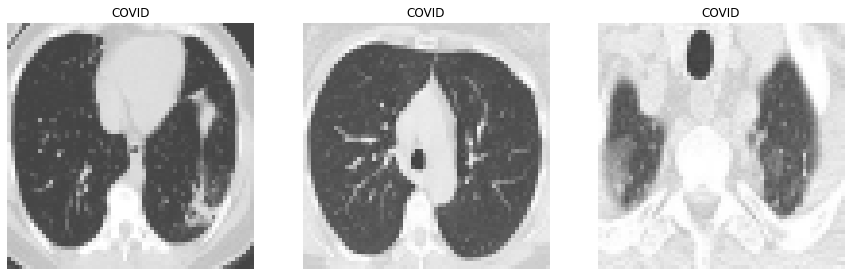

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [22]:
EPOCHS = 50
SIZE=64
N_ch=3

In [23]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## DenseNet121 Model

In [24]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',f1_m, precision_m, recall_m])
    model.summary()
    
    return model

## Data Augmentation and Fitting Model 

In [25]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val),
               )

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-25-b6203377aad7>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/50

Epoch 1: val_loss improved from inf to 0.85468, saving model to model.h5
31/31 - 30s - loss: 1.2233 - accuracy: 0.5439 - f1_m: 0.5439 - precision_m: 0.5439 - recall_m: 0.5439 - val_loss: 0.8547 - val_accuracy: 0.4366 - val_f1_m: 0.4324 - val_precision_m: 0.4324 - val_recall_m: 0.4324 - lr: 0.0020 - 30s/epoch - 959ms/step
Epoch 2/50

Epoch 2: val_loss did not improve from 0.85468
31/31 - 4s - loss: 1.0062 - accuracy: 0.6064 - f1_m: 0.6064 - precision_m: 0.6064 - recall_m: 0.6064 - val_loss: 1.4512 - val_accuracy: 0.4467 - val_f1_m: 0.4439 - val_precision_m: 0.4439 - val_recall_m: 0.4439 - lr: 0.0020 - 4s/epoch - 115ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.85468
31/31 - 5s - loss: 0.8941 - accuracy: 0.6472 - f1_m: 0.6472 - precision_m: 0.6472 - recall_m: 0.6472 - val_loss: 1.3070 - val_accuracy: 0.4547 - val_f1_m: 0.4535 - val_precision_m: 0.4535 - val_recall_m: 0.4535 - lr: 0.0020 - 5s/epoch - 151ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 

## Final Loss and Accuracy

In [30]:
#model = load_model('../output/kaggle/working/model.h5')
loss, acc, f1_score, precision, recall = model.evaluate(X_val, Y_val, verbose=0)
print(f"\n LOSS: {loss},\n\n ACCURACY: {acc},\n\n F1_SCORE: {f1_score},\n\n PRECISION: {precision},\n\n RECALL: {recall}\n")



 LOSS: 0.2970520555973053,

 ACCURACY: 0.877263605594635,

 F1_SCORE: 0.8774126172065735,

 PRECISION: 0.8774126768112183,

 RECALL: 0.8774126768112183



## Confusion Matrix

16/16 [==============================] - 2s 15ms/step


Text(0.5, 145.31999999999996, 'Predicted')

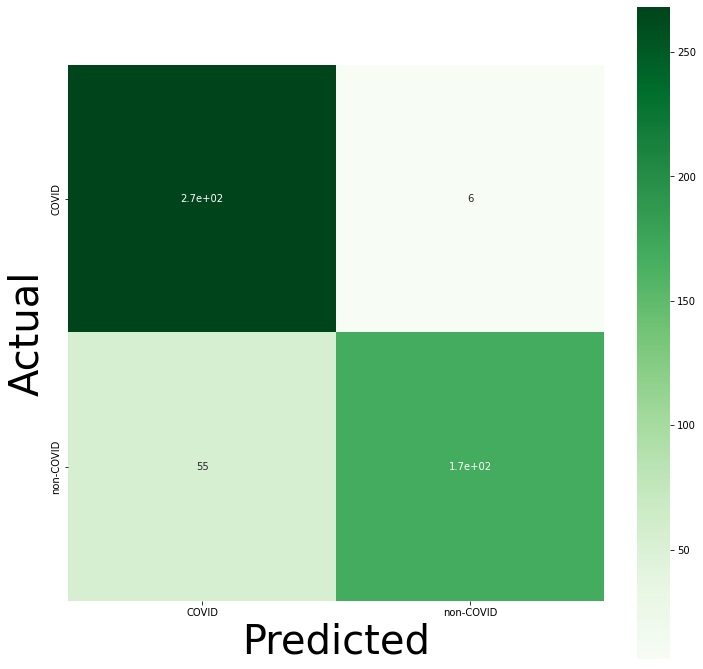

In [27]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Accuracy and Loss Curve

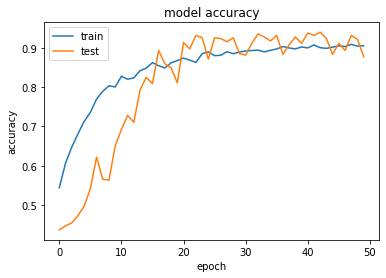

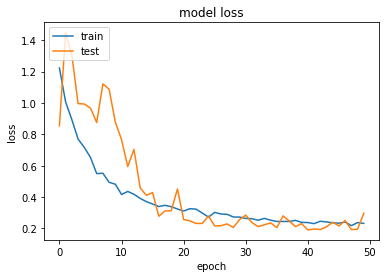

In [28]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction from Image

1/1 [==============================] - 1s 665ms/step
[9.9998081e-01 1.9193567e-05]


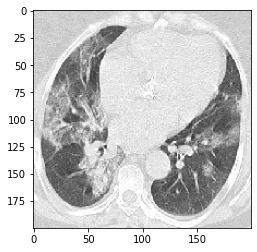

Prediction: Covid-19


In [29]:
from skimage import io
import keras.utils as image

#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])